# Symbolic Image Filtering

In [1]:
import pymbolic.primitives as p

u_var = p.Variable("u")

Want to define an image filter.

----

To that end, define a new formula 'thing': A neighbor-average.

In [2]:
class NeighborAverage(p.Expression):
    def __init__(self, child):
        self.child = child
        
    def __getinitargs__(self):
        return (self.child,)
    
    mapper_method = "map_neighbor_average"
        
img_filter = NeighborAverage(u_var)
#img_filter = u_var + u_var - NeighborAverage(u_var)

img_filter

NeighborAverage(Variable('u'))

Let's define some indexing variables:

In [3]:
from pymbolic.mapper import IdentityMapper

i = p.Variable("i")
j = p.Variable("j")

ii = i+1
jj = j+1

In [4]:
class IndexMapper(IdentityMapper):
    def map_variable(self, expr):
        return expr[ii, jj]
    
    def map_neighbor_average(self, expr):
        var = expr.child
        return (2*var[ii,jj] + var[ii+1,jj] + var[ii-1,jj]
                + var[ii,jj+1] + var[ii,jj-1])/6

Now apply this to our filter:

In [5]:
idx_mapper = IndexMapper()
print(idx_mapper(img_filter))

(2*u[i + 1, j + 1] + u[i + 1 + 1, j + 1] + u[i + 1 + -1, j + 1] + u[i + 1, j + 1 + 1] + u[i + 1, j + 1 + -1]) / 6


----

Now let's generate some code for this, using `loopy`:

In [8]:
import loopy as lp
from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2

result_var = p.Variable("result")

Observe the two parts of the `loopy` kernel description:

* Polyhedral loop domain
* Instructions `[lp.ExpressionInstruction()]`

In [10]:
#clear
knl = lp.make_kernel(
    "{[i,j]: 0<=i,j<n}",
    [lp.Assignment(
            result_var[ii,jj], idx_mapper(img_filter))],
    [lp.GlobalArg("result", shape="n+2, n+2"), ...]
    )

Kernels can always be inspected--simply use `print`:

In [11]:
print(knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
n: ValueArg, type: <auto/runtime>
result: type: <auto/runtime>, shape: (n + 2, n + 2), dim_tags: (N1:stride:n + 2, N0:stride:1) aspace: global
u: type: <auto/runtime>, shape: (2 + n, 2 + n), dim_tags: (N1:stride:2 + n, N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i, j] : 0 <= i < n and 0 <= j < n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
for j, i
    result[i + 1, j + 1] = (2*u[i + 1, j + 1] + u[i + 1 + 1, j + 1] + u[i + 1 + -1, j + 1] + u[i + 1, j + 1 + 1] + u[i + 1, j + 1 + -1]) / 6  {id=insn}
end j, i
-----------------------------------------------------------

----

Let's move towards running this code. To do so, we need `pyopencl`:

In [14]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom

ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7f87cfbe26e8>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x2e90b58>


Choice [0]: 


Set the environment variable PYOPENCL_CTX='' to avoid being asked again.


And some data to work with:

In [18]:
n = 200

import imageio
u = imageio.imread("cat.jpeg").astype(np.float32).sum(axis=2)/(3*256)
u = cl.array.to_device(queue, u)

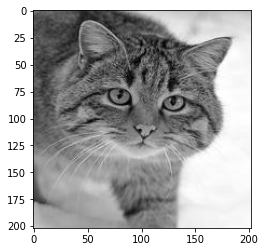

In [19]:
import matplotlib.pyplot as pt
pt.imshow(u.get(), cmap="gray")

Now run the code, and tell loopy to print what it generates:

In [20]:
knl = lp.set_options(knl, write_cl=True)

result = cl.array.zeros_like(u)
_ = knl(queue, u=u, result=result, n=n)
u = result

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel(__global float *__restrict__ result, int const n, __global float const *__restrict__ u)
{
  for (int j = 0; j <= -1 + n; ++j)
    for (int i = 0; i <= -1 + n; ++i)
      result[(n + 2) * (1 + i) + 1 + j] = (2.0f * u[(2 + n) * (1 + i) + 1 + j] + u[(2 + n) * (2 + i) + 1 + j] + u[(2 + n) * i + 1 + j] + u[(2 + n) * (1 + i) + 2 + j] + u[(2 + n) * (1 + i) + j]) / 6.0f;
}



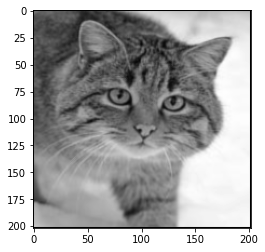

In [21]:
pt.imshow(u.get(), cmap="gray", vmin=0, vmax=1)

That's obviously not very parallel. Introduce parallelism:

In [22]:
tknl = knl
tknl = lp.tag_inames(tknl, {"i": "g.0", "j": "g.1"})
evt, (result,) = tknl(queue, u=u)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel(__global float *__restrict__ result, int const n, __global float const *__restrict__ u)
{
  result[(n + 2) * (1 + gid(0)) + 1 + gid(1)] = (2.0f * u[(2 + n) * (1 + gid(0)) + 1 + gid(1)] + u[(2 + n) * (2 + gid(0)) + 1 + gid(1)] + u[(2 + n) * gid(0) + 1 + gid(1)] + u[(2 + n) * (1 + gid(0)) + 2 + gid(1)] + u[(2 + n) * (1 + gid(0)) + gid(1)]) / 6.0f;
}



But OpenCL/CUDA require blocking to be efficient!

In [23]:
sknl = knl
sknl = lp.split_iname(sknl,
        "i", 16, outer_tag="g.1", inner_tag="l.1")
sknl = lp.split_iname(sknl,
        "j", 16, outer_tag="g.0", inner_tag="l.0")
evt, (result,) = sknl(queue, u=u)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(16, 16, 1))) loopy_kernel(__global float *__restrict__ result, int const n, __global float const *__restrict__ u)
{
  if (-1 + -16 * gid(0) + -1 * lid(0) + n >= 0 && -1 + -16 * gid(1) + -1 * lid(1) + n >= 0)
    result[(n + 2) * (1 + 16 * gid(1) + lid(1)) + 1 + 16 * gid(0) + lid(0)] = (2.0f * u[(2 + n) * (1 + 16 * gid(1) + lid(1)) + 1 + 16 * gid(0) + lid(0)] + u[(2 + n) * (2 + 16 * gid(1) + lid(1)) + 1 + 16 * gid(0) + lid(0)] + u[(2 + n) * (16 * gid(1) + lid(1)) + 1 + 16 * gid(0) + lid(0)] + u[(2 + n) * (1 + 16 * gid(1) + lid(1)) + 2 + 16 * gid(0) + lid(0)] + u[(2 + n) * (1 + 16 * gid(1) + lid(1)) + 16 * gid(0) + lid(0)]) / 6.0f;
}



How about some data reuse?

In [27]:
sknl = knl
sknl = lp.split_iname(sknl,
        "i", 16, outer_tag="g.1", inner_tag="l.1")
sknl = lp.split_iname(sknl,
        "j", 16, outer_tag="g.0", inner_tag="l.0")
sknl = lp.add_prefetch(sknl, "u",
    ["i_inner", "j_inner"],
    fetch_bounding_box=True, default_tag="l.auto")
evt, (result,) = sknl(queue, u=u, n=n)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(16, 16, 1))) loopy_kernel(__global float *__restrict__ result, int const n, __global float const *__restrict__ u)
{
  __local float u_fetch[18 * 18];

  if (1 + -16 * gid(0) + -1 * lid(0) + n >= 0 && 1 + -16 * gid(1) + -1 * lid(1) + n >= 0)
    for (int u_dim_1_outer = 0; u_dim_1_outer <= (-1 + n + -1 * lid(1) + -16 * gid(1) >= 0 && -16 + n + -16 * gid(0) >= 0 ? 1 + -1 * lid(0) + (1 + 15 * lid(0)) / 16 : -1 * gid(0) + -1 * lid(0) + (1 + n + 15 * lid(0)) / 16); ++u_dim_1_outer)
      if (17 + -16 * u_dim_1_outer + -1 * lid(0) >= 0)
        for (int u_dim_0_outer = 0; u_dim_0_outer <= (-16 + n + -16 * gid(1) >= 0 && -1 + n + -1 * lid(0) + -16 * gid(0) >= 0 ? 1 + -1 * lid(1) + (1 + 15 * lid(1)) / 16 : -1 * gid(1) + -1 * lid(1) + (1 + n + 15 * lid(1)) / 16); ++u_dim_0_outer)
          if (17 + -16 * u_dim_0_outer + -1 * lid(1) >= 0)
            u_fetch[18 * (16 

In [32]:
cpuknl = knl
cpuknl = lp.split_iname(cpuknl, "i", 16, outer_tag="g.0")
cpuknl = lp.split_iname(cpuknl, "j", 8, inner_tag="l.0", slabs=(0,1))
cpuknl = lp.prioritize_loops(cpuknl, "i_inner, j_outer")

evt, (result,) = cpuknl(queue, u=u, n=n)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#define LOOPY_CALL_WITH_INTEGER_TYPES(MACRO_NAME) \
    MACRO_NAME(int8, char) \
    MACRO_NAME(int16, short) \
    MACRO_NAME(int32, int) \
    MACRO_NAME(int64, long)
#define LOOPY_DEFINE_FLOOR_DIV_POS_B(SUFFIX, TYPE) \
    inline TYPE loopy_floor_div_pos_b_##SUFFIX(TYPE a, TYPE b) \
    { \
        if (a<0) \
            a = a - (b-1); \
        return a/b; \
    }
LOOPY_CALL_WITH_INTEGER_TYPES(LOOPY_DEFINE_FLOOR_DIV_POS_B)
#undef LOOPY_DEFINE_FLOOR_DIV_POS_B
#undef LOOPY_CALL_WITH_INTEGER_TYPES

__kernel void __attribute__ ((reqd_work_group_size(8, 1, 1))) loopy_kernel(__global float *__restrict__ result, int const n, __global float const *__restrict__ u)
{
  if (-1 + -1 * lid(0) + n >= 0)
    for (int i_inner = 0; i_inner <= (-16 + n + -16 * gid(0) >= 0 ? 15 : -1 + n + -16 * gid(0)); ++i_inner)
    {
      /* bulk slab for 'j_outer' */
      for (int j_outer = 0; j_outer <= -2 + loopy_floor_div_pos_b_int

## Judgement day: Has it helped?

Let's time the execution of our "blur" operation on an actually big image. (We'll make do with random data for this timing):

In [33]:
from time import time

rounds = 4

n = 5000
u = cl.clrandom.rand(queue, (n+2, n+2), dtype=np.float32)

uh = u.get()

First, `numpy`:

In [34]:
t_start = time()
for i in range(rounds):
    blurred_u = np.zeros_like(uh)
    blurred_u[1:-1, 1:-1] = (
        2*uh[1:-1, 1:-1]
        + uh[2:, 1:-1]
        + uh[:-2, 1:-1]
        + uh[1:-1, 2:]
        + uh[1:-1, 2:]
        )/6

print((time()-t_start)/rounds)

0.1049642562866211


Next, our generated code:

In [35]:
queue.finish()
t_start = time()
for i in range(rounds):
    evt, (result,) = cpuknl(queue, u=u)
    
queue.finish()
codegen_time = (time()-t_start)/rounds
print(codegen_time)

0.023528873920440674


Now estimate performance:

In [36]:
pixels_accessed = 6*n**2
bytes_accessed = pixels_accessed * 4
gbytes_per_second = bytes_accessed / codegen_time / 1e9
print(gbytes_per_second)

25.500582902046617
